1. Setup & Imports 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import load_model
import tensorflow as tf
import warnings
from datetime import datetime, timedelta
import os
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2. Load and Clean the Data

In [2]:
print("Loading and preprocessing data with focused improvements...")
df = pd.read_csv('Air Quality Ho Chi Minh City.csv', parse_dates=['date'], dayfirst=True)

# Filter and sort data
df = df[df['Station_No'] == 2].sort_values('date')

# Select columns
cols = ['PM2.5', 'O3', 'CO', 'NO2', 'SO2', 'Temperature', 'Humidity']
df = df[['date'] + cols].copy()

# Clean data conversion
for col in cols:
    if df[col].dtype == object:
        df[col] = df[col].str.replace('[^0-9.]', '', regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Smart missing value handling
print(f"Missing values before: {df[cols].isnull().sum().sum()}")

for col in cols:
    # Linear interpolation for short gaps
    df[col] = df[col].interpolate(method='linear', limit=6)
    
    # For remaining gaps, use hourly median pattern
    if df[col].isnull().sum() > 0:
        hourly_median = df.groupby(df['date'].dt.hour)[col].median()
        missing_mask = df[col].isnull()
        for idx in missing_mask[missing_mask].index:
            hour = df.loc[idx, 'date'].hour
            if not pd.isna(hourly_median[hour]):
                df.loc[idx, col] = hourly_median[hour]
    
    # Final cleanup
    df[col] = df[col].ffill().bfill()

print(f"Missing values after: {df[cols].isnull().sum().sum()}")

# Improved outlier handling (less aggressive)
print("Smart outlier detection and handling...")
outlier_indices = set()

for col in cols:
    Q1 = df[col].quantile(0.15)  # Less aggressive quartiles
    Q3 = df[col].quantile(0.85)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2.0 * IQR  # More conservative bounds
    upper_bound = Q3 + 2.0 * IQR
    
    # Find outliers but don't replace immediately
    col_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
    outlier_indices.update(col_outliers)

# Replace outliers with rolling median (7-hour window)
for idx in outlier_indices:
    for col in cols:
        window_start = max(0, idx - 3)
        window_end = min(len(df), idx + 4)
        if window_end - window_start >= 3:
            median_val = df[col].iloc[window_start:window_end].median()
            df.loc[idx, col] = median_val

print(f"Processed {len(outlier_indices)} potential outlier data points")

Loading and preprocessing data with focused improvements...
Missing values before: 9008
Missing values after: 0
Smart outlier detection and handling...
Processed 157 potential outlier data points


3. Feature Engineering

In [3]:
print("Strategic feature engineering...")

# Essential time features
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Cyclical encoding for key temporal patterns
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
df['sin_day'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['cos_day'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Key interaction features (proven to be important)
df['temp_humidity'] = df['Temperature'] * df['Humidity']
df['O3_NO2_ratio'] = df['O3'] / (df['NO2'] + 1e-6)
df['pollutant_index'] = df['CO'] + df['NO2'] + df['SO2']

# Essential lag features (most predictive)
for lag in [1, 2, 3, 6, 12, 24]:
    df[f'PM2.5_lag_{lag}h'] = df['PM2.5'].shift(lag)

# Rolling statistics (key windows only)
for window in [3, 6, 12, 24]:
    df[f'PM2.5_mean_{window}h'] = df['PM2.5'].rolling(window=window, center=True).mean()
    df[f'PM2.5_std_{window}h'] = df['PM2.5'].rolling(window=window, center=True).std()

# Rate of change (trend indicators)
df['PM2.5_diff_1h'] = df['PM2.5'].diff(1)
df['PM2.5_diff_3h'] = df['PM2.5'].diff(3)

# Weather change indicators
df['temp_diff'] = df['Temperature'].diff(1)
df['humidity_diff'] = df['Humidity'].diff(1)

# Remove rows with NaN
df.dropna(inplace=True)
print(f"Data shape after feature engineering: {df.shape}")

Strategic feature engineering...
Data shape after feature engineering: (9322, 36)


4. Train/Test Split & Sequence Creation

In [4]:
print("Optimized data preparation...")

# Select most important features 
selected_features = [
    # Core pollutants
    'PM2.5', 'O3', 'CO', 'NO2', 'SO2', 
    # Weather
    'Temperature', 'Humidity',
    # Time patterns
    'sin_hour', 'cos_hour', 'sin_day', 'cos_day', 'is_weekend',
    # Interactions
    'temp_humidity', 'O3_NO2_ratio', 'pollutant_index',
    # Lags (most important)
    'PM2.5_lag_1h', 'PM2.5_lag_2h', 'PM2.5_lag_3h', 'PM2.5_lag_6h', 'PM2.5_lag_12h', 'PM2.5_lag_24h',
    # Rolling stats (key ones)
    'PM2.5_mean_3h', 'PM2.5_mean_6h', 'PM2.5_mean_12h', 'PM2.5_mean_24h',
    'PM2.5_std_3h', 'PM2.5_std_12h',
    # Trends
    'PM2.5_diff_1h', 'PM2.5_diff_3h', 'temp_diff', 'humidity_diff'
]

print(f"Selected {len(selected_features)} features")

# Use StandardScaler 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[selected_features])

# Create sequences 
def create_sequences(data, target_idx, n_steps=36):  # 36 hours = 1.5 days
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i, target_idx])
    return np.array(X), np.array(y)

pm25_idx = selected_features.index('PM2.5')
X, y = create_sequences(scaled_data, pm25_idx, n_steps=36)

print(f"Sequence shape: {X.shape}, Target shape: {y.shape}")

# Split data 
split_idx = int(0.9 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Optimized data preparation...
Selected 31 features
Sequence shape: (9286, 36, 31), Target shape: (9286,)
Train: (8357, 36, 31), Test: (929, 36, 31)


5. Build & Train the LSTM Model

In [5]:
print("Building optimized model...")

model = Sequential([
    # First Bidirectional LSTM layer 
    Bidirectional(LSTM(128, return_sequences=True, 
                      dropout=0.1, recurrent_dropout=0.1,
                      kernel_regularizer=l2(0.001)),
                  input_shape=(36, len(selected_features))),
    BatchNormalization(),
    
    # Second Bidirectional LSTM layer
    Bidirectional(LSTM(96, return_sequences=True,
                      dropout=0.15, recurrent_dropout=0.1,
                      kernel_regularizer=l2(0.001))),
    BatchNormalization(),
    
    # Third LSTM layer 
    LSTM(64, dropout=0.2, recurrent_dropout=0.1),
    BatchNormalization(),
    
    # Dense layers with strategic dropout
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.1),
    
    # Output layer
    Dense(1)
])

# Optimized compiler settings
optimizer = Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

print(f"Model parameters: {model.count_params():,}")

# Improved callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.6,
        patience=10,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'optimized_pm25_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Strategic Training
print("Training optimized model...")

history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,  # Good balance from your original
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

Building optimized model...
Model parameters: 521,473
Training optimized model...
Epoch 1/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 1.6620 - mae: 0.6264
Epoch 1: val_loss improved from inf to 1.11621, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 24s 73ms/step - loss: 1.6610 - mae: 0.6259 - val_loss: 1.1162 - val_mae: 0.4015 - learning_rate: 8.0000e-04
Epoch 2/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1.1854 - mae: 0.4208
Epoch 2: val_loss improved from 1.11621 to 0.92860, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 69ms/step - loss: 1.1853 - mae: 0.4208 - val_loss: 0.9286 - val_mae: 0.3325 - learning_rate: 8.0000e-04
Epoch 3/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 1.0062 - mae: 0.3677
Epoch 3: val_loss improved from 0.92860 to 0.77747, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - loss: 1.0060 - mae: 0.3677 - val_loss: 0.7775 - val_mae: 0.2780 - learning_rate: 8.0000e-04
Epoch 4/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.8678 - mae: 0.3465
Epoch 4: val_loss improved from 0.77747 to 0.67310, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - loss: 0.8677 - mae: 0.3464 - val_loss: 0.6731 - val_mae: 0.2684 - learning_rate: 8.0000e-04
Epoch 5/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.7544 - mae: 0.3285
Epoch 5: val_loss improved from 0.67310 to 0.56566, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 157ms/step - loss: 0.7543 - mae: 0.3285 - val_loss: 0.5657 - val_mae: 0.2360 - learning_rate: 8.0000e-04
Epoch 6/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.6535 - mae: 0.3138
Epoch 6: val_loss improved from 0.56566 to 0.50341, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 33s 149ms/step - loss: 0.6535 - mae: 0.3138 - val_loss: 0.5034 - val_mae: 0.2352 - learning_rate: 8.0000e-04
Epoch 7/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.5827 - mae: 0.3074
Epoch 7: val_loss improved from 0.50341 to 0.42890, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 155ms/step - loss: 0.5827 - mae: 0.3073 - val_loss: 0.4289 - val_mae: 0.2334 - learning_rate: 8.0000e-04
Epoch 8/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.4974 - mae: 0.2841
Epoch 8: val_loss improved from 0.42890 to 0.37608, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 33s 148ms/step - loss: 0.4973 - mae: 0.2840 - val_loss: 0.3761 - val_mae: 0.2135 - learning_rate: 8.0000e-04
Epoch 9/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.4504 - mae: 0.2841
Epoch 9: val_loss improved from 0.37608 to 0.33734, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - loss: 0.4504 - mae: 0.2841 - val_loss: 0.3373 - val_mae: 0.2336 - learning_rate: 8.0000e-04
Epoch 10/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.3983 - mae: 0.2657
Epoch 10: val_loss improved from 0.33734 to 0.29141, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 40s 148ms/step - loss: 0.3982 - mae: 0.2656 - val_loss: 0.2914 - val_mae: 0.2141 - learning_rate: 8.0000e-04
Epoch 11/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.3701 - mae: 0.2684
Epoch 11: val_loss improved from 0.29141 to 0.26045, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - loss: 0.3700 - mae: 0.2684 - val_loss: 0.2605 - val_mae: 0.2067 - learning_rate: 8.0000e-04
Epoch 12/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.3155 - mae: 0.2559
Epoch 12: val_loss did not improve from 0.26045
222/222 ━━━━━━━━━━━━━━━━━━━━ 39s 146ms/step - loss: 0.3154 - mae: 0.2559 - val_loss: 0.2644 - val_mae: 0.2151 - learning_rate: 8.0000e-04
Epoch 13/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.3292 - mae: 0.2640
Epoch 13: val_loss improved from 0.26045 to 0.22027, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - loss: 0.3291 - mae: 0.2640 - val_loss: 0.2203 - val_mae: 0.2030 - learning_rate: 8.0000e-04
Epoch 14/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2754 - mae: 0.2494
Epoch 14: val_loss improved from 0.22027 to 0.20335, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 40s 149ms/step - loss: 0.2754 - mae: 0.2494 - val_loss: 0.2034 - val_mae: 0.2023 - learning_rate: 8.0000e-04
Epoch 15/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2551 - mae: 0.2385
Epoch 15: val_loss improved from 0.20335 to 0.17043, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - loss: 0.2551 - mae: 0.2385 - val_loss: 0.1704 - val_mae: 0.1628 - learning_rate: 8.0000e-04
Epoch 16/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.2379 - mae: 0.2356
Epoch 16: val_loss improved from 0.17043 to 0.16686, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 33s 148ms/step - loss: 0.2378 - mae: 0.2356 - val_loss: 0.1669 - val_mae: 0.1809 - learning_rate: 8.0000e-04
Epoch 17/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2417 - mae: 0.2469
Epoch 17: val_loss improved from 0.16686 to 0.14421, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 154ms/step - loss: 0.2416 - mae: 0.2469 - val_loss: 0.1442 - val_mae: 0.1701 - learning_rate: 8.0000e-04
Epoch 18/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2164 - mae: 0.2310
Epoch 18: val_loss did not improve from 0.14421
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - loss: 0.2164 - mae: 0.2310 - val_loss: 0.1467 - val_mae: 0.1780 - learning_rate: 8.0000e-04
Epoch 19/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2095 - mae: 0.2261
Epoch 19: val_loss improved from 0.14421 to 0.13104, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 152ms/step - loss: 0.2094 - mae: 0.2260 - val_loss: 0.1310 - val_mae: 0.1722 - learning_rate: 8.0000e-04
Epoch 20/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.1824 - mae: 0.2164
Epoch 20: val_loss improved from 0.13104 to 0.11542, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 35s 158ms/step - loss: 0.1824 - mae: 0.2164 - val_loss: 0.1154 - val_mae: 0.1595 - learning_rate: 8.0000e-04
Epoch 21/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1647 - mae: 0.2090
Epoch 21: val_loss improved from 0.11542 to 0.10036, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 151ms/step - loss: 0.1647 - mae: 0.2090 - val_loss: 0.1004 - val_mae: 0.1308 - learning_rate: 8.0000e-04
Epoch 22/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1540 - mae: 0.2043
Epoch 22: val_loss did not improve from 0.10036
222/222 ━━━━━━━━━━━━━━━━━━━━ 32s 145ms/step - loss: 0.1540 - mae: 0.2043 - val_loss: 0.1024 - val_mae: 0.1412 - learning_rate: 8.0000e-04
Epoch 23/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1520 - mae: 0.2038
Epoch 23: val_loss improved from 0.10036 to 0.08765, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 31s 138ms/step - loss: 0.1520 - mae: 0.2038 - val_loss: 0.0877 - val_mae: 0.1251 - learning_rate: 8.0000e-04
Epoch 24/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.1501 - mae: 0.2062
Epoch 24: val_loss improved from 0.08765 to 0.08073, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 31s 141ms/step - loss: 0.1501 - mae: 0.2062 - val_loss: 0.0807 - val_mae: 0.1204 - learning_rate: 8.0000e-04
Epoch 25/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.1463 - mae: 0.2019
Epoch 25: val_loss did not improve from 0.08073
222/222 ━━━━━━━━━━━━━━━━━━━━ 31s 139ms/step - loss: 0.1463 - mae: 0.2019 - val_loss: 0.0875 - val_mae: 0.1511 - learning_rate: 8.0000e-04
Epoch 26/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.1232 - mae: 0.1904
Epoch 26: val_loss did not improve from 0.08073
222/222 ━━━━━━━━━━━━━━━━━━━━ 42s 143ms/step - loss: 0.1232 - mae: 0.1904 - val_loss: 0.0822 - val_mae: 0.1370 - learning_rate: 8.0000e-04
Epoch 27/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1308 - mae: 0.1952
Epoch 27: val_loss did not improve from 0.08073
222/222 ━━━━━━━━━━━━━━━━━━━━ 31s 140ms/step - loss: 0.1309 - mae: 0.1952 - val_loss: 0.0940 - val_mae: 0.1572 - learning_rate: 8.0000e-04
Epoch 28/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 136m

222/222 ━━━━━━━━━━━━━━━━━━━━ 42s 143ms/step - loss: 0.1364 - mae: 0.1975 - val_loss: 0.0792 - val_mae: 0.1299 - learning_rate: 8.0000e-04
Epoch 29/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.1290 - mae: 0.1904
Epoch 29: val_loss did not improve from 0.07920
222/222 ━━━━━━━━━━━━━━━━━━━━ 40s 137ms/step - loss: 0.1290 - mae: 0.1904 - val_loss: 0.0956 - val_mae: 0.1762 - learning_rate: 8.0000e-04
Epoch 30/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.1184 - mae: 0.1858
Epoch 30: val_loss did not improve from 0.07920
222/222 ━━━━━━━━━━━━━━━━━━━━ 32s 143ms/step - loss: 0.1184 - mae: 0.1858 - val_loss: 0.0879 - val_mae: 0.1659 - learning_rate: 8.0000e-04
Epoch 31/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1253 - mae: 0.1951
Epoch 31: val_loss did not improve from 0.07920
222/222 ━━━━━━━━━━━━━━━━━━━━ 31s 138ms/step - loss: 0.1253 - mae: 0.1951 - val_loss: 0.0838 - val_mae: 0.1272 - learning_rate: 8.0000e-04
Epoch 32/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 135m

222/222 ━━━━━━━━━━━━━━━━━━━━ 42s 142ms/step - loss: 0.1216 - mae: 0.1881 - val_loss: 0.0627 - val_mae: 0.1121 - learning_rate: 8.0000e-04
Epoch 33/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1119 - mae: 0.1863
Epoch 33: val_loss did not improve from 0.06273
222/222 ━━━━━━━━━━━━━━━━━━━━ 31s 139ms/step - loss: 0.1119 - mae: 0.1863 - val_loss: 0.0637 - val_mae: 0.1248 - learning_rate: 8.0000e-04
Epoch 34/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1036 - mae: 0.1762
Epoch 34: val_loss did not improve from 0.06273
222/222 ━━━━━━━━━━━━━━━━━━━━ 33s 103ms/step - loss: 0.1036 - mae: 0.1762 - val_loss: 0.0659 - val_mae: 0.1369 - learning_rate: 8.0000e-04
Epoch 35/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1071 - mae: 0.1790
Epoch 35: val_loss did not improve from 0.06273
222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - loss: 0.1071 - mae: 0.1790 - val_loss: 0.0756 - val_mae: 0.1253 - learning_rate: 8.0000e-04
Epoch 36/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/st

222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - loss: 0.0990 - mae: 0.1745 - val_loss: 0.0532 - val_mae: 0.1175 - learning_rate: 8.0000e-04
Epoch 41/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0866 - mae: 0.1658
Epoch 41: val_loss did not improve from 0.05316
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - loss: 0.0866 - mae: 0.1658 - val_loss: 0.0600 - val_mae: 0.1443 - learning_rate: 8.0000e-04
Epoch 42/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0893 - mae: 0.1640
Epoch 42: val_loss improved from 0.05316 to 0.05000, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - loss: 0.0893 - mae: 0.1640 - val_loss: 0.0500 - val_mae: 0.1008 - learning_rate: 8.0000e-04
Epoch 43/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0905 - mae: 0.1684
Epoch 43: val_loss did not improve from 0.05000
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - loss: 0.0905 - mae: 0.1684 - val_loss: 0.0634 - val_mae: 0.1611 - learning_rate: 8.0000e-04
Epoch 44/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0849 - mae: 0.1613
Epoch 44: val_loss did not improve from 0.05000
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 0.0850 - mae: 0.1613 - val_loss: 0.0594 - val_mae: 0.1316 - learning_rate: 8.0000e-04
Epoch 45/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.1027 - mae: 0.1820
Epoch 45: val_loss did not improve from 0.05000
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - loss: 0.1027 - mae: 0.1819 - val_loss: 0.0828 - val_mae: 0.2044 - learning_rate: 8.0000e-04
Epoch 46/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step -

222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - loss: 0.0865 - mae: 0.1637 - val_loss: 0.0419 - val_mae: 0.0991 - learning_rate: 8.0000e-04
Epoch 50/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0880 - mae: 0.1650
Epoch 50: val_loss did not improve from 0.04189
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - loss: 0.0880 - mae: 0.1650 - val_loss: 0.0493 - val_mae: 0.1212 - learning_rate: 8.0000e-04
Epoch 51/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0798 - mae: 0.1603
Epoch 51: val_loss did not improve from 0.04189
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - loss: 0.0798 - mae: 0.1603 - val_loss: 0.0695 - val_mae: 0.1835 - learning_rate: 8.0000e-04
Epoch 52/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0841 - mae: 0.1601
Epoch 52: val_loss did not improve from 0.04189
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - loss: 0.0841 - mae: 0.1601 - val_loss: 0.0601 - val_mae: 0.1362 - learning_rate: 8.0000e-04
Epoch 53/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step -

222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - loss: 0.0892 - mae: 0.1614 - val_loss: 0.0405 - val_mae: 0.1054 - learning_rate: 8.0000e-04
Epoch 59/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0751 - mae: 0.1520
Epoch 59: val_loss did not improve from 0.04053
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - loss: 0.0751 - mae: 0.1520 - val_loss: 0.0470 - val_mae: 0.1183 - learning_rate: 8.0000e-04
Epoch 60/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0746 - mae: 0.1548
Epoch 60: val_loss did not improve from 0.04053
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - loss: 0.0746 - mae: 0.1548 - val_loss: 0.0441 - val_mae: 0.1077 - learning_rate: 8.0000e-04
Epoch 61/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0835 - mae: 0.1559
Epoch 61: val_loss did not improve from 0.04053
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - loss: 0.0835 - mae: 0.1559 - val_loss: 0.0461 - val_mae: 0.1239 - learning_rate: 8.0000e-04
Epoch 62/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step -

222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - loss: 0.0669 - mae: 0.1439 - val_loss: 0.0374 - val_mae: 0.1078 - learning_rate: 4.8000e-04
Epoch 70/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0614 - mae: 0.1362
Epoch 70: val_loss improved from 0.03740 to 0.03409, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - loss: 0.0614 - mae: 0.1362 - val_loss: 0.0341 - val_mae: 0.0946 - learning_rate: 4.8000e-04
Epoch 71/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0607 - mae: 0.1385
Epoch 71: val_loss improved from 0.03409 to 0.03318, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - loss: 0.0606 - mae: 0.1384 - val_loss: 0.0332 - val_mae: 0.1025 - learning_rate: 4.8000e-04
Epoch 72/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0556 - mae: 0.1327
Epoch 72: val_loss did not improve from 0.03318
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - loss: 0.0556 - mae: 0.1327 - val_loss: 0.0439 - val_mae: 0.1344 - learning_rate: 4.8000e-04
Epoch 73/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0622 - mae: 0.1396
Epoch 73: val_loss did not improve from 0.03318
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - loss: 0.0622 - mae: 0.1396 - val_loss: 0.0356 - val_mae: 0.1035 - learning_rate: 4.8000e-04
Epoch 74/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0579 - mae: 0.1342
Epoch 74: val_loss did not improve from 0.03318
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - loss: 0.0579 - mae: 0.1342 - val_loss: 0.0375 - val_mae: 0.1098 - learning_rate: 4.8000e-04
Epoch 75/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step -

222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - loss: 0.0548 - mae: 0.1310 - val_loss: 0.0310 - val_mae: 0.0945 - learning_rate: 4.8000e-04
Epoch 76/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0567 - mae: 0.1327
Epoch 76: val_loss did not improve from 0.03105
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - loss: 0.0567 - mae: 0.1327 - val_loss: 0.0393 - val_mae: 0.1287 - learning_rate: 4.8000e-04
Epoch 77/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0539 - mae: 0.1305
Epoch 77: val_loss did not improve from 0.03105
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - loss: 0.0539 - mae: 0.1305 - val_loss: 0.0355 - val_mae: 0.1086 - learning_rate: 4.8000e-04
Epoch 78/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0576 - mae: 0.1363
Epoch 78: val_loss did not improve from 0.03105
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - loss: 0.0576 - mae: 0.1363 - val_loss: 0.0383 - val_mae: 0.1246 - learning_rate: 4.8000e-04
Epoch 79/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step -

222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - loss: 0.0517 - mae: 0.1306 - val_loss: 0.0309 - val_mae: 0.0903 - learning_rate: 4.8000e-04
Epoch 82/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0534 - mae: 0.1293
Epoch 82: val_loss did not improve from 0.03087
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 0.0534 - mae: 0.1293 - val_loss: 0.0505 - val_mae: 0.1480 - learning_rate: 4.8000e-04
Epoch 83/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0627 - mae: 0.1436
Epoch 83: val_loss did not improve from 0.03087
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 0.0627 - mae: 0.1435 - val_loss: 0.0372 - val_mae: 0.1177 - learning_rate: 4.8000e-04
Epoch 84/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0660 - mae: 0.1405
Epoch 84: val_loss improved from 0.03087 to 0.02952, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 0.0660 - mae: 0.1405 - val_loss: 0.0295 - val_mae: 0.0831 - learning_rate: 4.8000e-04
Epoch 85/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0556 - mae: 0.1308
Epoch 85: val_loss improved from 0.02952 to 0.02857, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 0.0556 - mae: 0.1308 - val_loss: 0.0286 - val_mae: 0.0898 - learning_rate: 4.8000e-04
Epoch 86/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0591 - mae: 0.1301
Epoch 86: val_loss improved from 0.02857 to 0.02845, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 0.0591 - mae: 0.1301 - val_loss: 0.0284 - val_mae: 0.0841 - learning_rate: 4.8000e-04
Epoch 87/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0569 - mae: 0.1333
Epoch 87: val_loss improved from 0.02845 to 0.02807, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 0.0569 - mae: 0.1333 - val_loss: 0.0281 - val_mae: 0.0887 - learning_rate: 4.8000e-04
Epoch 88/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0559 - mae: 0.1322
Epoch 88: val_loss did not improve from 0.02807
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 83ms/step - loss: 0.0559 - mae: 0.1322 - val_loss: 0.0375 - val_mae: 0.1221 - learning_rate: 4.8000e-04
Epoch 89/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0538 - mae: 0.1293
Epoch 89: val_loss did not improve from 0.02807
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 0.0538 - mae: 0.1293 - val_loss: 0.0354 - val_mae: 0.1159 - learning_rate: 4.8000e-04
Epoch 90/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0611 - mae: 0.1345
Epoch 90: val_loss did not improve from 0.02807
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 0.0611 - mae: 0.1345 - val_loss: 0.0372 - val_mae: 0.1023 - learning_rate: 4.8000e-04
Epoch 91/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step -

222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - loss: 0.0495 - mae: 0.1250 - val_loss: 0.0253 - val_mae: 0.0805 - learning_rate: 2.8800e-04
Epoch 99/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0433 - mae: 0.1186
Epoch 99: val_loss did not improve from 0.02531
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - loss: 0.0433 - mae: 0.1186 - val_loss: 0.0260 - val_mae: 0.0884 - learning_rate: 2.8800e-04
Epoch 100/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0484 - mae: 0.1227
Epoch 100: val_loss did not improve from 0.02531
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 0.0484 - mae: 0.1227 - val_loss: 0.0311 - val_mae: 0.1057 - learning_rate: 2.8800e-04
Epoch 101/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0496 - mae: 0.1247
Epoch 101: val_loss did not improve from 0.02531
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 0.0496 - mae: 0.1247 - val_loss: 0.0269 - val_mae: 0.0952 - learning_rate: 2.8800e-04
Epoch 102/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/s

222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 0.0444 - mae: 0.1205 - val_loss: 0.0249 - val_mae: 0.0886 - learning_rate: 2.8800e-04
Epoch 103/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0449 - mae: 0.1194
Epoch 103: val_loss did not improve from 0.02487
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - loss: 0.0449 - mae: 0.1194 - val_loss: 0.0290 - val_mae: 0.1052 - learning_rate: 2.8800e-04
Epoch 104/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0427 - mae: 0.1181
Epoch 104: val_loss did not improve from 0.02487
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - loss: 0.0427 - mae: 0.1181 - val_loss: 0.0275 - val_mae: 0.1008 - learning_rate: 2.8800e-04
Epoch 105/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0448 - mae: 0.1203
Epoch 105: val_loss did not improve from 0.02487
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - loss: 0.0448 - mae: 0.1203 - val_loss: 0.0301 - val_mae: 0.1064 - learning_rate: 2.8800e-04
Epoch 106/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms

222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - loss: 0.0420 - mae: 0.1178 - val_loss: 0.0247 - val_mae: 0.0884 - learning_rate: 2.8800e-04
Epoch 108/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0426 - mae: 0.1184
Epoch 108: val_loss did not improve from 0.02466
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - loss: 0.0426 - mae: 0.1184 - val_loss: 0.0305 - val_mae: 0.1055 - learning_rate: 2.8800e-04
Epoch 109/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0474 - mae: 0.1242
Epoch 109: val_loss did not improve from 0.02466
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 0.0474 - mae: 0.1242 - val_loss: 0.0257 - val_mae: 0.0963 - learning_rate: 2.8800e-04
Epoch 110/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0455 - mae: 0.1206
Epoch 110: val_loss improved from 0.02466 to 0.02436, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - loss: 0.0455 - mae: 0.1206 - val_loss: 0.0244 - val_mae: 0.0870 - learning_rate: 2.8800e-04
Epoch 111/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0425 - mae: 0.1174
Epoch 111: val_loss improved from 0.02436 to 0.02400, saving model to optimized_pm25_model.h5


222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - loss: 0.0426 - mae: 0.1174 - val_loss: 0.0240 - val_mae: 0.0808 - learning_rate: 2.8800e-04
Epoch 112/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0449 - mae: 0.1198
Epoch 112: val_loss did not improve from 0.02400
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - loss: 0.0449 - mae: 0.1198 - val_loss: 0.0284 - val_mae: 0.1084 - learning_rate: 2.8800e-04
Epoch 113/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0436 - mae: 0.1192
Epoch 113: val_loss did not improve from 0.02400
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - loss: 0.0435 - mae: 0.1192 - val_loss: 0.0274 - val_mae: 0.1084 - learning_rate: 2.8800e-04
Epoch 114/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0442 - mae: 0.1195
Epoch 114: val_loss did not improve from 0.02400
222/222 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - loss: 0.0442 - mae: 0.1195 - val_loss: 0.0277 - val_mae: 0.1003 - learning_rate: 2.8800e-04
Epoch 115/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 158

222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - loss: 0.0399 - mae: 0.1136 - val_loss: 0.0212 - val_mae: 0.0822 - learning_rate: 1.7280e-04
Epoch 123/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0380 - mae: 0.1129
Epoch 123: val_loss did not improve from 0.02125
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - loss: 0.0380 - mae: 0.1129 - val_loss: 0.0214 - val_mae: 0.0848 - learning_rate: 1.7280e-04
Epoch 124/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0377 - mae: 0.1116
Epoch 124: val_loss did not improve from 0.02125
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - loss: 0.0377 - mae: 0.1116 - val_loss: 0.0236 - val_mae: 0.0926 - learning_rate: 1.7280e-04
Epoch 125/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0396 - mae: 0.1125
Epoch 125: val_loss did not improve from 0.02125
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - loss: 0.0396 - mae: 0.1125 - val_loss: 0.0284 - val_mae: 0.1138 - learning_rate: 1.7280e-04
Epoch 126/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms

222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - loss: 0.0394 - mae: 0.1146 - val_loss: 0.0200 - val_mae: 0.0814 - learning_rate: 1.7280e-04
Epoch 132/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0380 - mae: 0.1149
Epoch 132: val_loss did not improve from 0.02001
222/222 ━━━━━━━━━━━━━━━━━━━━ 40s 168ms/step - loss: 0.0380 - mae: 0.1149 - val_loss: 0.0200 - val_mae: 0.0812 - learning_rate: 1.7280e-04
Epoch 133/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0349 - mae: 0.1093
Epoch 133: val_loss did not improve from 0.02001
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - loss: 0.0349 - mae: 0.1093 - val_loss: 0.0219 - val_mae: 0.0827 - learning_rate: 1.7280e-04
Epoch 134/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0388 - mae: 0.1205
Epoch 134: val_loss did not improve from 0.02001
222/222 ━━━━━━━━━━━━━━━━━━━━ 38s 171ms/step - loss: 0.0388 - mae: 0.1204 - val_loss: 0.0207 - val_mae: 0.0801 - learning_rate: 1.7280e-04
Epoch 135/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 

222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - loss: 0.0370 - mae: 0.1112 - val_loss: 0.0195 - val_mae: 0.0775 - learning_rate: 1.7280e-04
Epoch 139/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0362 - mae: 0.1109
Epoch 139: val_loss did not improve from 0.01951
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 155ms/step - loss: 0.0362 - mae: 0.1109 - val_loss: 0.0254 - val_mae: 0.1030 - learning_rate: 1.7280e-04
Epoch 140/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0409 - mae: 0.1128
Epoch 140: val_loss did not improve from 0.01951
222/222 ━━━━━━━━━━━━━━━━━━━━ 41s 154ms/step - loss: 0.0409 - mae: 0.1128 - val_loss: 0.0214 - val_mae: 0.0846 - learning_rate: 1.7280e-04
Epoch 141/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0380 - mae: 0.1139
Epoch 141: val_loss did not improve from 0.01951
222/222 ━━━━━━━━━━━━━━━━━━━━ 34s 152ms/step - loss: 0.0380 - mae: 0.1139 - val_loss: 0.0233 - val_mae: 0.0980 - learning_rate: 1.7280e-04
Epoch 142/150
222/222 ━━━━━━━━━━━━━━━━━━━━ 

6. Evaluation

In [6]:


print("Evaluating optimized model...")

# Load best weights
model.load_weights('optimized_pm25_model.h5')

# Predictions
y_pred = model.predict(X_test).flatten()

# Inverse transform predictions and actual values
dummy_features = len(selected_features)
pad_zeros = lambda arr: np.concatenate([arr.reshape(-1, 1), np.zeros((len(arr), dummy_features - 1))], axis=1)

y_test_actual = scaler.inverse_transform(pad_zeros(y_test))[:, pm25_idx]
y_pred_actual = scaler.inverse_transform(pad_zeros(y_pred))[:, pm25_idx]

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

safe_denom = np.where(y_test_actual == 0, 1, y_test_actual)
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / safe_denom)) * 100

# Accuracy metrics
accuracy_3 = np.mean(np.abs(y_test_actual - y_pred_actual) <= 3) * 100
accuracy_5 = np.mean(np.abs(y_test_actual - y_pred_actual) <= 5) * 100
accuracy_10 = np.mean(np.abs(y_test_actual - y_pred_actual) <= 10) * 100
accuracy_15 = np.mean(np.abs(y_test_actual - y_pred_actual) <= 15) * 100

# Directional accuracy
actual_trend = np.diff(y_test_actual) > 0
pred_trend = np.diff(y_pred_actual) > 0
directional_accuracy = np.mean(actual_trend == pred_trend) * 100

print("\n" + "="*70)
print("OPTIMIZED MODEL EVALUATION RESULTS")
print("="*70)
print(f"RMSE: {rmse:.2f} µg/m³")
print(f"MAE: {mae:.2f} µg/m³")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")
print("-" * 70)
print("ACCURACY THRESHOLDS:")
print(f"Accuracy (±3 µg/m³): {accuracy_3:.2f}%")
print(f"Accuracy (±5 µg/m³): {accuracy_5:.2f}%")
print(f"Accuracy (±10 µg/m³): {accuracy_10:.2f}%")
print(f"Accuracy (±15 µg/m³): {accuracy_15:.2f}%")
print("="*70)

Evaluating optimized model...
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step

OPTIMIZED MODEL EVALUATION RESULTS
RMSE: 0.89 µg/m³
MAE: 0.71 µg/m³
R²: 0.9863
MAPE: 5.01%
Directional Accuracy: 94.72%
----------------------------------------------------------------------
ACCURACY THRESHOLDS:
Accuracy (±3 µg/m³): 99.25%
Accuracy (±5 µg/m³): 100.00%
Accuracy (±10 µg/m³): 100.00%
Accuracy (±15 µg/m³): 100.00%


7. Comprehensive Visualization

Creating visualizations...


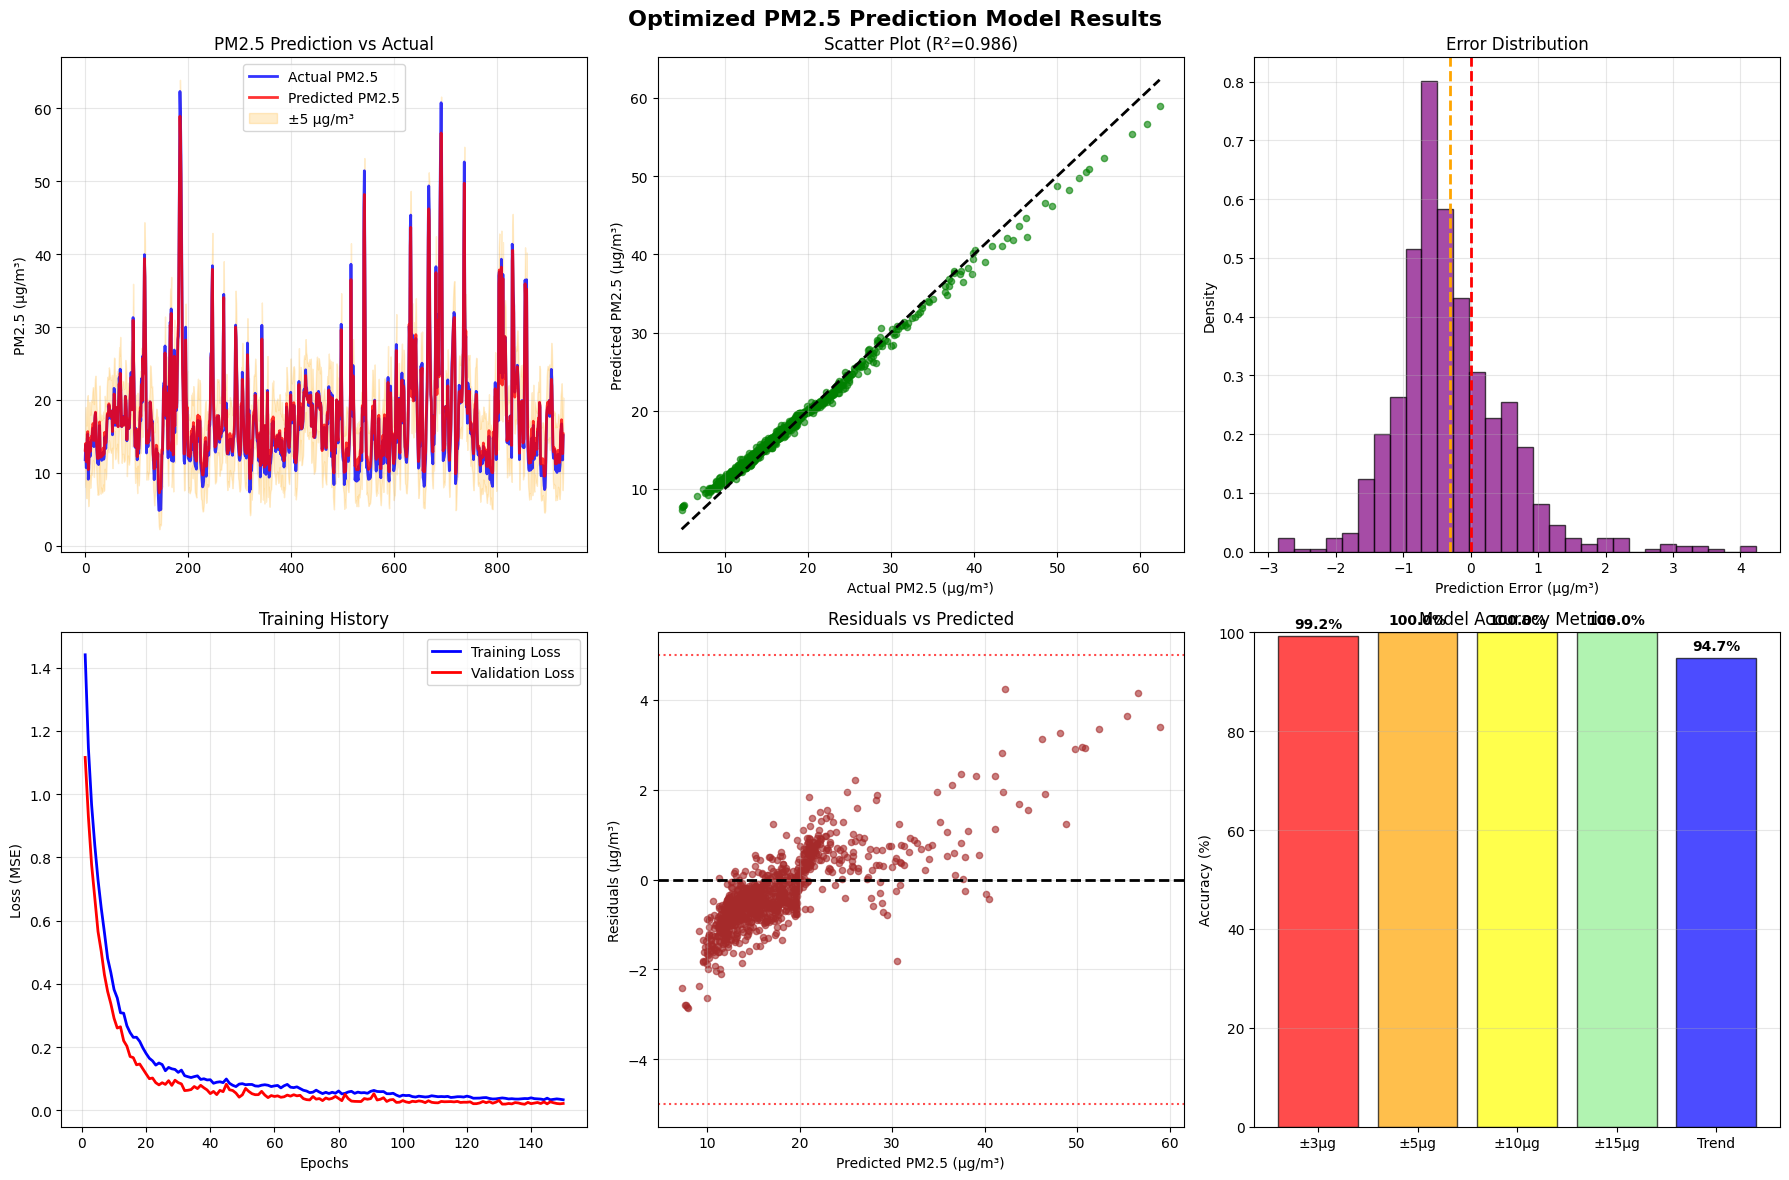

In [7]:
print("Creating visualizations...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Optimized PM2.5 Prediction Model Results', fontsize=16, fontweight='bold')

# 1. Prediction vs Actual
ax1 = axes[0, 0]
time_steps = range(len(y_test_actual))
ax1.plot(time_steps, y_test_actual, label='Actual PM2.5', linewidth=2, color='blue', alpha=0.8)
ax1.plot(time_steps, y_pred_actual, label='Predicted PM2.5', linewidth=2, color='red', alpha=0.8)
ax1.fill_between(time_steps, y_pred_actual - 5, y_pred_actual + 5,
                alpha=0.2, color='orange', label='±5 µg/m³')
ax1.set_title('PM2.5 Prediction vs Actual')
ax1.set_ylabel('PM2.5 (µg/m³)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Scatter plot
ax2 = axes[0, 1]
ax2.scatter(y_test_actual, y_pred_actual, alpha=0.6, color='green', s=20)
max_val = max(y_test_actual.max(), y_pred_actual.max())
min_val = min(y_test_actual.min(), y_pred_actual.min())
ax2.plot([min_val, max_val], [min_val, max_val], '--k', linewidth=2)
ax2.set_xlabel('Actual PM2.5 (µg/m³)')
ax2.set_ylabel('Predicted PM2.5 (µg/m³)')
ax2.set_title(f'Scatter Plot (R²={r2:.3f})')
ax2.grid(True, alpha=0.3)

# 3. Error distribution
ax3 = axes[0, 2]
error = y_test_actual - y_pred_actual
ax3.hist(error, bins=30, density=True, alpha=0.7, color='purple', edgecolor='black')
ax3.axvline(0, color='red', linestyle='--', linewidth=2)
ax3.axvline(error.mean(), color='orange', linestyle='--', linewidth=2)
ax3.set_xlabel('Prediction Error (µg/m³)')
ax3.set_ylabel('Density')
ax3.set_title('Error Distribution')
ax3.grid(True, alpha=0.3)

# 4. Training history
ax4 = axes[1, 0]
epochs = range(1, len(history.history['loss']) + 1)
ax4.plot(epochs, history.history['loss'], 'b-', linewidth=2, label='Training Loss')
ax4.plot(epochs, history.history['val_loss'], 'r-', linewidth=2, label='Validation Loss')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Loss (MSE)')
ax4.set_title('Training History')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Residuals
ax5 = axes[1, 1]
ax5.scatter(y_pred_actual, error, alpha=0.6, color='brown', s=20)
ax5.axhline(0, color='black', linestyle='--', linewidth=2)
ax5.axhline(5, color='red', linestyle=':', alpha=0.7)
ax5.axhline(-5, color='red', linestyle=':', alpha=0.7)
ax5.set_xlabel('Predicted PM2.5 (µg/m³)')
ax5.set_ylabel('Residuals (µg/m³)')
ax5.set_title('Residuals vs Predicted')
ax5.grid(True, alpha=0.3)

# 6. Accuracy metrics
ax6 = axes[1, 2]
metrics = ['±3µg', '±5µg', '±10µg', '±15µg', 'Trend']
values = [accuracy_3, accuracy_5, accuracy_10, accuracy_15, directional_accuracy]
colors = ['red', 'orange', 'yellow', 'lightgreen', 'blue']
bars = ax6.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black')
ax6.set_ylabel('Accuracy (%)')
ax6.set_title('Model Accuracy Metrics')
ax6.set_ylim(0, 100)

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('pm25_results.png', dpi=300, bbox_inches='tight')
plt.show()


8. Save Results

In [8]:
print("Saving results...")

# Save predictions
results_df = pd.DataFrame({
    'Actual_PM2.5': y_test_actual,
    'Predicted_PM2.5': y_pred_actual,
    'Error': error,
    'Absolute_Error': np.abs(error)
})
results_df.to_csv('optimized_pm25_predictions.csv', index=False)

Saving results...
